# Colab-specific Setup
Go to Runtime > Change runtime type > Set to GPU hardware

In [1]:
# # Optionally connect to your Google Drive account
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Clone github repo and cd into the scripts folder
!git clone https://github.com/MedARC-AI/fMRI-reconstruction-faces
%cd fMRI-reconstruction-faces/scripts/

Cloning into 'fMRI-reconstruction-faces'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 1), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), 4.55 KiB | 1.52 MiB/s, done.
/content/fMRI-reconstruction-faces/scripts


In [3]:
# Download data from huggingface
!wget -c https://huggingface.co/datasets/pscotti/facedataset/resolve/main/sg2_embeds.npy
!wget -c https://huggingface.co/datasets/pscotti/facedataset/resolve/main/sub-002/betas_1d.npy
!wget -c https://huggingface.co/datasets/pscotti/facedataset/resolve/main/sub-002/face_ids.npy

--2023-02-08 14:55:08--  https://huggingface.co/datasets/pscotti/facedataset/resolve/main/sg2_embeds.npy
Resolving huggingface.co (huggingface.co)... 3.231.67.228, 54.235.118.239, 2600:1f18:147f:e800:671:b733:ecf3:a585, ...
Connecting to huggingface.co (huggingface.co)|3.231.67.228|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/3b/3d/3b3d56d01ece766f001022dca902b030e50b0cf7bd4f1db6ad1ec92e3407dc95/2de65a48b68a91778da091d07b89c7c10fdbd9b04e952b3839cf55fb4f97a50a?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sg2_embeds.npy%3B+filename%3D%22sg2_embeds.npy%22%3B&Expires=1676127309&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzNiLzNkLzNiM2Q1NmQwMWVjZTc2NmYwMDEwMjJkY2E5MDJiMDMwZTUwYjBjZjdiZDRmMWRiNmFkMWVjOTJlMzQwN2RjOTUvMmRlNjVhNDhiNjhhOTE3NzhkYTA5MWQwN2I4OWM3YzEwZmRiZDliMDRlOTUyYjM4MzljZjU1ZmI0Zjk3YTUwYT9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoiLCJDb25kaXRp

# Import packages

In [4]:
import os
import sys
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import PIL

from utils import *

device = "cuda" if torch.cuda.is_available() else "cpu" 
print(device)

cuda


# Load data

In [5]:
# load flattened voxels with NaNs removed 
voxels = np.load(f'betas_1d.npy') 

y = np.load(f'face_ids.npy').astype(np.int16)

print(voxels.shape)
print(y.shape)

(1920, 136572)
(1920,)


In [6]:
# load sg-2 embeddings per sample
embeds = np.load('sg2_embeds.npy')
embeds = embeds[y]
embeds.shape

(1920, 512)

In [7]:
# set rng seed to make code & model training reproducible
seed_everything(seed=42)

# if you include different samples of face X in the training and test set, reconstructions look great:
# all_trials = np.random.permutation(np.arange(len(voxels)))
# train_trials = all_trials[all_trials[:1792]]
# val_trials = all_trials[all_trials[1792:]]

# if you ensure that the test set doesn't contain samples of the same face in the training set, reconstructions look bad:
train_trials = np.where(y<=700)[0]
val_trials = np.where(y>700)[0]

train_voxels = torch.Tensor(voxels[train_trials,:])
val_voxels = torch.Tensor(voxels[val_trials,:])
print("Voxels loaded.")

train_embs = torch.Tensor(embeds[train_trials,:])
val_embs = torch.Tensor(embeds[val_trials,:])
print("Embeddings loaded.")

print(train_voxels.shape, train_embs.shape)
print(val_voxels.shape, val_embs.shape)

Voxels loaded.
Embeddings loaded.
torch.Size([1660, 136572]) torch.Size([1660, 512])
torch.Size([260, 136572]) torch.Size([260, 512])


# Train model

In [8]:
assert torch.any(torch.isnan(train_voxels))==False
class BrainNetwork(nn.Module):
    def __init__(self, out_dim, in_dim=voxels.shape[1], h=1028):
        super().__init__()
        self.lin0 = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h),
            nn.Dropout(0.5),
        )
        self.mlp = nn.ModuleList([
            nn.Sequential(
                nn.Linear(h, h),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(h),
                nn.Dropout(0.15)
            ) for _ in range(2)
        ])  
        self.lin1 = nn.Linear(h,out_dim)
    def forward(self, x):
        x = self.lin0(x)
        residual = x
        for res_block in range(2):
            x = self.mlp[res_block](x)
            x += residual
            residual = x
        x = x.reshape(len(x),-1)
        x = self.lin1(x)
        return x
voxels2emb = BrainNetwork(512).to(device)

mse = nn.MSELoss()
initial_learning_rate = 3e-4
optimizer = torch.optim.AdamW(voxels2emb.parameters(), lr=initial_learning_rate)

num_epochs = 30
batch_size = 32

data_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(train_voxels,#[torch.randperm(len(train_voxels))], 
                                                                                 train_embs),
                                                                    batch_size=batch_size, shuffle=True)
data_loader_val = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(val_voxels, 
                                                                                 val_embs),
                                                                    batch_size=batch_size, shuffle=False)

train_losses = []; val_losses = []; lrs = [];
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    voxels2emb.train()
    epoch_loss = 0
    for train_i, (voxel, emb) in enumerate(data_loader):
        voxel = voxel.to(device)
        emb = emb.to(device)
        
        optimizer.zero_grad(set_to_none=True) # reset gradients
        
        emb_ = voxels2emb(voxel)
        
        loss = mse(emb,emb_) 

        loss.backward() # backpropagate
        optimizer.step() # gradient descent
        
        epoch_loss += loss.item()
        
        lrs.append(optimizer.param_groups[0]['lr'])
        
    train_losses.append(epoch_loss/(train_i+1))
        
    voxels2emb.eval()
    epoch_val_loss = 0
    for val_i, (val_voxel, val_emb) in enumerate(data_loader_val):
        val_voxel = val_voxel.to(device)
        val_emb = val_emb.to(device)
        
        with torch.no_grad():
            val_emb_ = voxels2emb(val_voxel)
        
        val_loss = mse(val_emb,val_emb_)
        epoch_val_loss += val_loss.item()
        
    val_losses.append(epoch_val_loss/(val_i+1))
        
    pbar.set_description(f"Train Loss: {np.mean(train_losses[-1]):.3f} | Val Loss: {np.mean(val_losses[-1]):.3f}")
print("DONE!")

Train Loss: 0.034 | Val Loss: 0.225: 100%|██████████| 30/30 [01:53<00:00,  3.77s/it]

DONE!


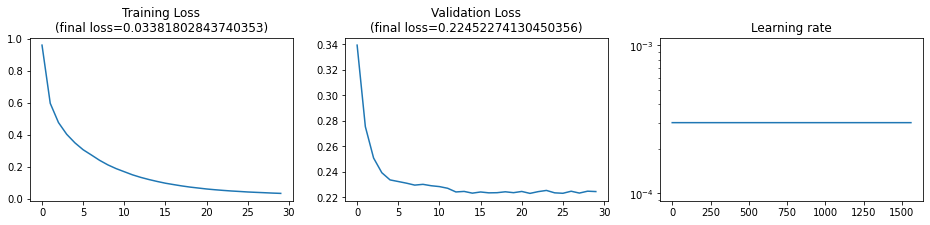

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,3))
ax1.set_title(f"Training Loss\n(final loss={train_losses[-1]})")
ax1.plot(train_losses)
ax2.set_title(f"Validation Loss\n(final loss={val_losses[-1]})")
ax2.plot(val_losses)
ax3.set_title("Learning rate")
ax3.plot(lrs)
ax3.set_yscale('log')
plt.show()

# Visualize reconstructions
## StyleGAN setup

In [10]:
# Clone stylegan2 github repo
if os.path.isdir("/content/drive/MyDrive/colab-sg2-ada-pytorch"):
    %cd "/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch"
elif os.path.isdir("/content/drive/"):
    %cd "/content/drive/MyDrive/"
    !git clone https://github.com/dvschultz/stylegan2-ada-pytorch
    %cd stylegan2-ada-pytorch
else:
    !git clone https://github.com/dvschultz/stylegan2-ada-pytorch
    %cd stylegan2-ada-pytorch

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 544, done.
remote: Total 544 (delta 0), reused 0 (delta 0), pack-reused 544
Receiving objects: 100% (544/544), 8.42 MiB | 25.43 MiB/s, done.
Resolving deltas: 100% (308/308), done.
/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch


In [11]:
# StyleGAN specific installations 
!pip install torch==1.8.1 torchvision==0.9.1 ninja click requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.1/804.1 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 20.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.8.1 which is incompatible.
torchaudio 0.13.1+cu116 requires

In [12]:
# Download pretrained face model
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl

--2023-02-08 14:59:02--  https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 52.84.162.36, 52.84.162.31, 52.84.162.5, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|52.84.162.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381673535 (364M) [application/x-www-form-urlencoded]
Saving to: ‘stylegan2-ffhq-config-f.pkl’

stylegan2-ffhq-conf 100%[===================>] 363.99M   183MB/s    in 2.0s    

2023-02-08 14:59:05 (183 MB/s) - ‘stylegan2-ffhq-config-f.pkl’ saved [381673535/381673535]



In [13]:
# Load pretrained model
import dnnlib
import legacy
network_pkl = 'stylegan2-ffhq-config-f.pkl'
print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema']
    G = G.eval().requires_grad_(False).to(device)  

Loading networks from "stylegan2-ffhq-config-f.pkl"...


## Plot face reconstructions
(If someone could figure out a way to fix the upfirdn2d_plugin errors that occur below that would be nice -- it works without error on my non-Colab local version of this script.)

Train Loss: 0.034 | Val Loss: 0.225
TRAINING
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

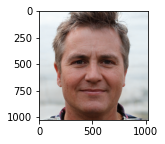

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

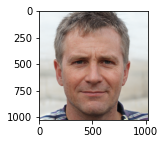

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

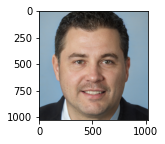

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

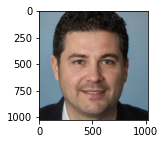

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

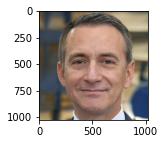

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

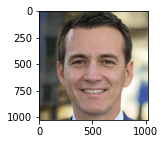

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

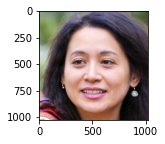

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

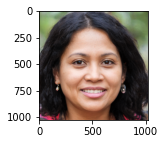


VALIDATION
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

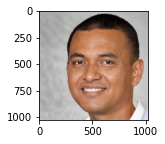

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

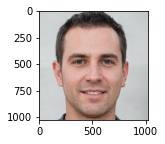

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

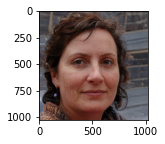

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

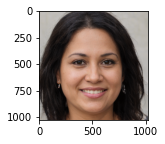

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

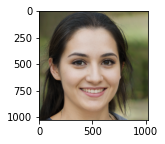

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

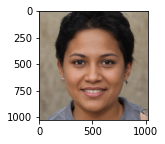

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

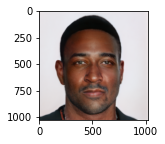

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!


/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py:34: UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
  File "/content/fMRI-reconstruction-faces/scripts/stylegan2-ada-pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1079, in load
    return _jit_compile(
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py", line 1317, in _jit_compile
    return _import_module_from_library(name, build_directo

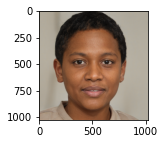

In [16]:
print(f"Train Loss: {np.mean(train_losses[-1]):.3f} | Val Loss: {np.mean(val_losses[-1]):.3f}")
print('TRAINING')
bs=6 if len(val_emb)>4 else len(val_emb)
for i in range(bs):
    plt.figure(figsize=(2,2))
    z = torch.Tensor.repeat(emb[i],(18,1)).to(device)[None]
    pic_ = G.synthesis(z, noise_mode='const')
    plt.imshow(torch_to_matplotlib(pic_))
    plt.grid(False)
    plt.show()
    plt.figure(figsize=(2,2))
    z = torch.Tensor.repeat(emb_[i],(18,1)).to(device)[None]
    pic_ = G.synthesis(z, noise_mode='const')
    plt.imshow(torch_to_matplotlib(pic_))
    plt.grid(False)
    plt.show()

print('\nVALIDATION')

for i in range(bs):
    plt.figure(figsize=(2,2))
    z = torch.Tensor.repeat(val_emb[i],(18,1)).to(device)[None]
    pic_ = G.synthesis(z, noise_mode='const')
    plt.imshow(torch_to_matplotlib(pic_))
    plt.grid(False)
    plt.show()
    plt.figure(figsize=(2,2))
    z = torch.Tensor.repeat(val_emb_[i],(18,1)).to(device)[None]
    pic_ = G.synthesis(z, noise_mode='const')
    plt.imshow(torch_to_matplotlib(pic_))
    plt.grid(False)
    plt.show()